In [ ]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


README:  Code for INN-Autoencoder for anomaly detection on ECG.  Basis for papers about INN-based inference pipeline validation.

Used in Jan 2024 to generate synthetic data from INN adjusted as VAE.  Feed INN-VAE with a random noise 28x28 and see a ECG-like image come out

In [ ]:
# drive.flush_and_unmount('/content/drive')

In [ ]:
%cd /content/drive/MyDrive/Colab\ Notebooks/INN-AutoEncoder/
!pwd
#!ls -ls FrEIA


/content/drive/MyDrive/Colab Notebooks/INN-AutoEncoder
/content/drive/MyDrive/Colab Notebooks/INN-AutoEncoder


In [ ]:
##### ECG

In [ ]:
import torch
import numpy as np
import pandas as pd
import tensorflow as tf
import matplotlib.pyplot as plt

from sklearn.metrics import accuracy_score, precision_score, recall_score
from sklearn.model_selection import train_test_split
from tensorflow.keras import layers, losses
from tensorflow.keras.models import Model

In [ ]:
!pip install scikit-fda

     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 434.7/434.7 kB 9.4 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 55.5/55.5 kB 6.3 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 4.6/4.6 MB 42.6 MB/s eta 0:00:00
  Installing build dependencies ... done
  Getting requirements to build wheel ... done
  Preparing metadata (pyproject.toml) ... done
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 46.5/46.5 kB 6.0 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 50.4/50.4 kB 6.9 MB/s eta 0:00:00
  Created wheel for fdasrsf: filename=fdasrsf-2.5.10-cp310-cp310-linux_x86_64.whl size=3081588 sha256=3c2050d3cea7433d1128c5bc1d7a84a40de38285f42f4e8f845a00baeb293b00
  Stored in directory: /root/.cache/pip/wheels/e8/52/1c/c4c363a070fc6643f741e1e7ecaae39377bc19130052054270
Successfully built fdasrsf


In [ ]:

from skfda.representation.basis import BSpline
from skfda.representation import FDataGrid, FDataBasis


Dataset from https://github.com/reese3222/fda-ecg5000/blob/main/fda-ecg5000.ipynb

https://www.researchgate.net/publication/354000854_Latent_Network_Construction_for_Univariate_Time_Series_Based_on_Variational_Auto-Encode



In [ ]:
test = pd.read_csv(f'datasets/ECG5000_TRAIN.arff', header=None)
train = pd.read_csv(f'datasets/ECG5000_TEST.arff', header=None)
data_all = pd.concat([test,train])
print(data_all.shape)

(5000, 141)


In [ ]:
raw_data_1 = data_all.loc[data_all.iloc[:,-1] == 1]
raw_data_2 = data_all.loc[data_all.iloc[:,-1] == 2]
raw_data_3 = data_all.loc[data_all.iloc[:,-1] == 3]
raw_data_4 = data_all.loc[data_all.iloc[:,-1] == 4]
raw_data_5 = data_all.loc[data_all.iloc[:,-1] == 5]

In [ ]:
raw_data_1_abnormal = pd.concat([raw_data_2,raw_data_3,raw_data_4,raw_data_5])
raw_data_2_abnormal = pd.concat([raw_data_3,raw_data_4,raw_data_5])
raw_data_3_abnormal = pd.concat([raw_data_2,raw_data_4,raw_data_5])
raw_data_4_abnormal = pd.concat([raw_data_2,raw_data_3,raw_data_5])
raw_data_5_abnormal = pd.concat([raw_data_2,raw_data_3,raw_data_4])

In [ ]:
print("data_1:", raw_data_1.shape)
print("data_2:", raw_data_2.shape)
print("data_3:", raw_data_3.shape)
print("data_4:", raw_data_4.shape)
print("data_5:", raw_data_5.shape)

data_1: (2919, 141)
data_2: (1767, 141)
data_3: (96, 141)
data_4: (194, 141)
data_5: (24, 141)


In [ ]:
### Graph

In [ ]:
y_train = train.iloc[:, -1]
y_test = test.iloc[:, -1]

In [ ]:
y_train.unique()

array([1, 2, 3, 4, 5])

In [ ]:
y_train.value_counts()

140
1    292
2    177
4     19
3     10
5      2
Name: count, dtype: int64

In [ ]:
y_test.unique()

array([1, 2, 3, 4, 5])

In [ ]:
y_test.value_counts()

140
1    2627
2    1590
4     175
3      86
5      22
Name: count, dtype: int64

Text(0.5, 0.98, 'ECG5000 training dataset')

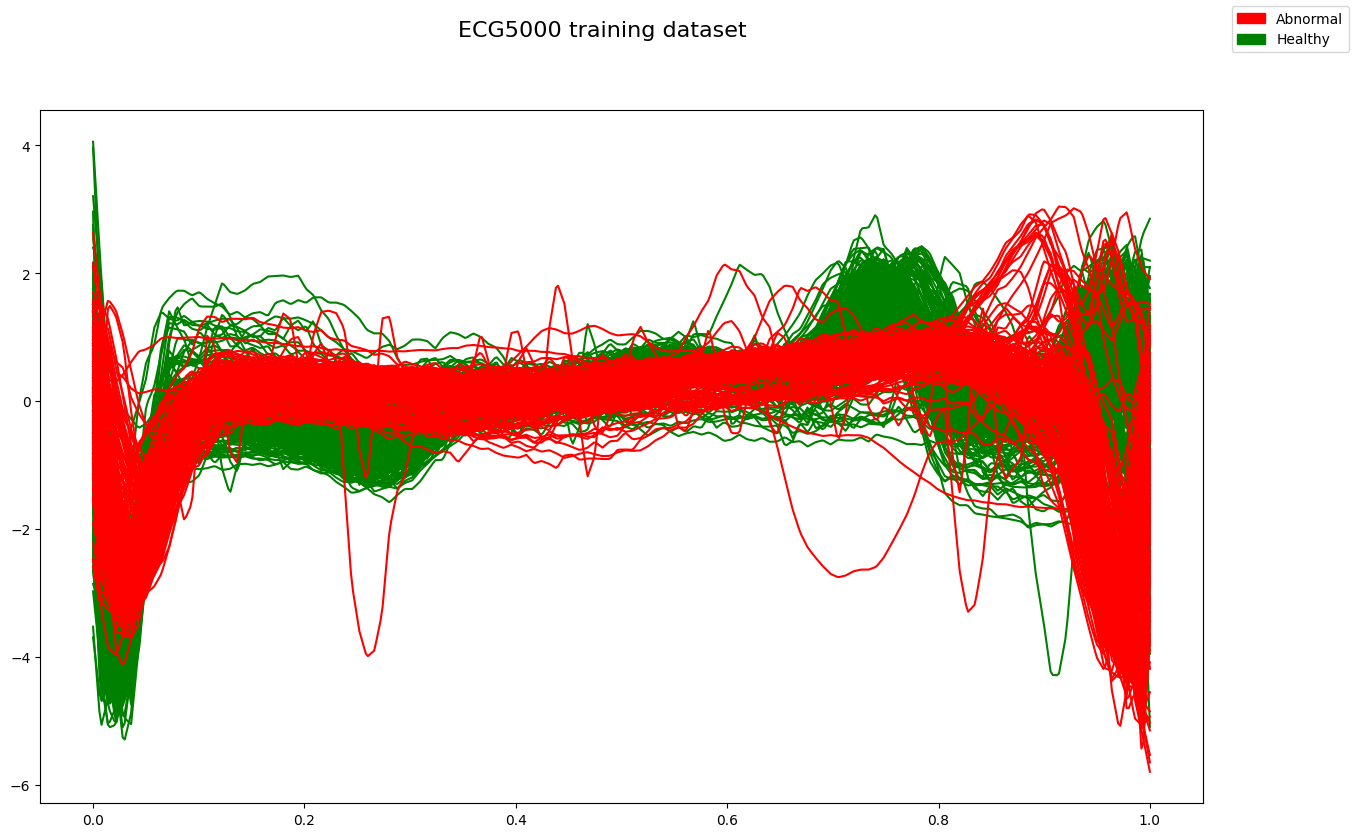

In [ ]:
y_train = train.iloc[:, -1]
y_train = [1 if i == 1 else 0 for i in y_train]
X_train = train.iloc[:, :-1]
y_test = test.iloc[:, -1]
y_test = [1 if i == 1 else 0 for i in y_test]
X_test = test.iloc[:, :-1]

X_test_plot = FDataGrid(X_test)
fig = plt.figure(figsize=(15, 9), dpi = 100)

X_test_plot.plot(fig = fig,
                    group = y_test,
                    group_colors = ['red', 'green'],
                    group_names = ['Abnormal', 'Healthy']
                    )

fig.suptitle(f'ECG5000 training dataset', fontsize=16)

# plt.savefig(f'figures/ECG5000.png' , format='png', dpi=300)

In [ ]:
# Separate data and labels

In [ ]:
# Dataset 1
labels_1 = raw_data_1.values[:,-1]
data_1 = raw_data_1.values[:, 0:-1]
labels_1_abnormal = raw_data_1_abnormal.values[:,-1]
data_1_abnormal = raw_data_1_abnormal.values[:, 0:-1]

# Dataset 2
labels_2 = raw_data_2.values[:,-1]
data_2 = raw_data_2.values[:, 0:-1]
labels_2_abnormal = raw_data_2_abnormal.values[:,-1]
data_2_abnormal = raw_data_2_abnormal.values[:, 0:-1]

# Dataset 3
labels_3 = raw_data_3.values[:,-1]
data_3 = raw_data_3.values[:, 0:-1]
labels_3_abnormal = raw_data_3_abnormal.values[:,-1]
data_3_abnormal = raw_data_3_abnormal.values[:, 0:-1]

# Dataset 4
labels_4 = raw_data_4.values[:,-1]
data_4 = raw_data_4.values[:, 0:-1]
labels_4_abnormal = raw_data_4_abnormal.values[:,-1]
data_4_abnormal = raw_data_4_abnormal.values[:, 0:-1]

# Dataset 5
labels_5 = raw_data_5.values[:,-1]
data_5 = raw_data_5.values[:, 0:-1]
labels_5_abnormal = raw_data_5_abnormal.values[:,-1]
data_5_abnormal = raw_data_5_abnormal.values[:, 0:-1]

In [ ]:
###  Repeat for all datasets, only run one at a time

In [ ]:
# Dataset 1
normal_data = data_1
normal_labels = labels_1

abnormal_data = data_1_abnormal
abnormal_labels = labels_1_abnormal

In [ ]:
# Dataset 2
normal_data = data_2
normal_labels = labels_2

abnormal_data = data_2_abnormal
abnormal_labels = labels_2_abnormal

In [ ]:
# Dataset 3
normal_data = data_3
normal_labels = labels_3

abnormal_data = data_3_abnormal
abnormal_labels = labels_3_abnormal

In [ ]:
# Dataset 4
normal_data = data_4
normal_labels = labels_4

abnormal_data = data_4_abnormal
abnormal_labels = labels_4_abnormal

In [ ]:
# Dataset 5
normal_data = data_5
normal_labels = labels_5

abnormal_data = data_5_abnormal
abnormal_labels = labels_5_abnormal

In [ ]:
print("normal_data.shape: ", normal_data.shape, " normal_labels.shape: ", normal_labels.shape)
print("abnormal_data.shape: ", abnormal_data.shape, " abnormal_labels.shape: ", abnormal_labels.shape)

normal_data.shape:  (24, 140)  normal_labels.shape:  (24,)
abnormal_data.shape:  (2057, 140)  abnormal_labels.shape:  (2057,)


In [ ]:
# Normalize normal data
min_val = tf.reduce_min(normal_data)
max_val = tf.reduce_max(normal_data)

normal_data = (normal_data - min_val) / (max_val - min_val)
normal_data = tf.cast(normal_data, tf.float32) # type tensorflow.python.framework.ops.EagerTensor
normal_data = np.array(normal_data)

In [ ]:
# Abnormal data is used for validation (training param: validloader)

# Normalize abnormal data
min_val = tf.reduce_min(abnormal_data)
max_val = tf.reduce_max(abnormal_data)

abnormal_data = (abnormal_data - min_val) / (max_val - min_val)
abnormal_data = tf.cast(abnormal_data, tf.float32) # type tensorflow.python.framework.ops.EagerTensor
abnormal_data = np.array(abnormal_data)

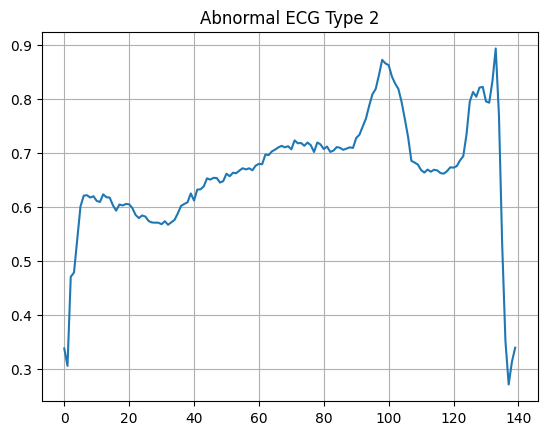

In [ ]:
# Plot Examples.
# Term "inlier" pertains to the dataset selected for traninig
# Term "outlier" pertains to the abnormal/validation dataset
plt.grid()
plt.plot(np.arange(140), normal_data[50])
plt.title("Inlier ECG Sample")
plt.show()

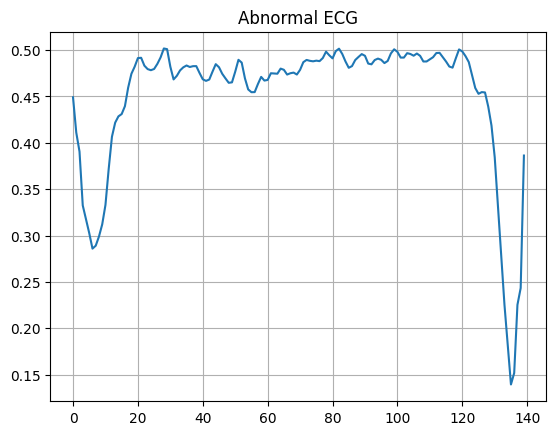

In [ ]:
# Plot
plt.grid()
plt.plot(np.arange(140), abnormal_data[0])
plt.title("Outlier ECG Sample")
plt.show()

In [ ]:
# Training will be only on normal data

train_data, test_data, train_labels, test_labels = train_test_split(
    normal_data, normal_labels, test_size=0.2, random_state=21
)

In [ ]:
# This transforms time-series samples from 140 (1D) to 10x14 (2D) to use CNN
# Reshape train data to 3D
print(train_data.shape)
train_data_3D = np.reshape(train_data,(-1,1,10,14))
print(train_data_3D.shape)

# Reshape test data to 3D
print(test_data.shape)
test_data_3D = np.reshape(test_data,(-1,1,10,14))
print(test_data_3D.shape)

(19, 140)
(19, 1, 10, 14)
(5, 140)
(5, 1, 10, 14)


In [ ]:
# Reshape abnormal validation data to 3D
print(abnormal_data.shape)
abnormal_data_3D = np.reshape(abnormal_data,(-1,1,10,14))
print(abnormal_data_3D.shape)

(2057, 140)
(2057, 1, 10, 14)


In [ ]:
# Convert numpy array to sequence, then to tensor
def convert_to_tensor_my(np_array):
  #seq = df.astype(np.float).to_numpy().tolist() # if df was passed
  seq = np_array.tolist()
  ds = [torch.tensor(s).unsqueeze(1).float() for s in seq]
  seq_num, seq_len, features_num = torch.stack(ds).shape
  return ds, seq_len, features_num

In [ ]:
# Create a Dataset https://androidkt.com/load-pandas-dataframe-using-dataset-and-dataloader-in-pytorch/
from torch.utils.data import Dataset
from torch.utils.data import DataLoader


class MyDataset_2D(Dataset):
  def __init__(self,dataframe):
    df = dataframe
    x = df.iloc[:,0:-1].values
    y = df.iloc[:,-1].values

    self.x_train=torch.tensor(x,dtype=torch.float32)
    self.y_train=torch.tensor(y,dtype=torch.float32)

  def __len__(self):
    return len(self.y_train)

  def __getitem__(self,idx):
    return self.x_train[idx],self.y_train[idx]

class MyDataset_3D(Dataset):
  def __init__(self,np_data_3D, np_labels):

    self.x_train=torch.tensor(np_data_3D,dtype=torch.float32)
    #self.y_train=torch.tensor(np_labels,dtype=torch.float32)
    self.y_train=np_labels

    #self.x_train = tf.convert_to_tensor(np_data_3D)
    #self.y_train = tf.convert_to_tensor(np_labels)

    #self.x_train, seq_len, features_num = convert_to_tensor_my(np_data_3D)
    #self.y_train, seq_len, features_num = convert_to_tensor_my(np_labels)

  def __len__(self):
    return len(self.y_train)

  def __getitem__(self,idx):
    return self.x_train[idx],self.y_train[idx]


In [ ]:
# Construct 3D Datasets
train_dataset_3D = MyDataset_3D(train_data_3D, train_labels)
test_dataset_3D = MyDataset_3D(test_data_3D, test_labels)

In [ ]:
abnormal_dataset_3D = MyDataset_3D(abnormal_data_3D, abnormal_labels)

In [ ]:
# Construct 3D Dataloders
batch_size=64
trainloader=DataLoader(train_dataset_3D,batch_size=batch_size,shuffle=False)
testloader=DataLoader(test_dataset_3D,batch_size=batch_size,shuffle=False)
abnormalloader=DataLoader(abnormal_dataset_3D,batch_size=batch_size,shuffle=False)

In [ ]:

from tqdm import tqdm_notebook as tqdm
from functionalities import tracker as tk
from functionalities import MMD_autoencoder_loss as cl
from functionalities import filemanager as fm
from functionalities import plot as pl
from functionalities import gpu

In [ ]:
from FrEIA import framework as fr
from FrEIA.modules import coeff_functs as fu
from FrEIA.modules import coupling_layers as la
from FrEIA.modules import reshapes as re

In [ ]:

def ecg_inn_fun(mask_size=[10, 14]):  # [28,28]
    """
    Return an autoencoder.
    :param mask_size: size of the input. Default: Size of ECG samples
    :return:
    """

    img_dims = [1, mask_size[0], mask_size[1]]

    inp = fr.InputNode(*img_dims, name='input')
    r1 = fr.Node([inp.out0], re.haar_multiplex_layer, {}, name='r1')
    conv1 = fr.Node([r1.out0], la.glow_coupling_layer, {'F_class': fu.F_conv,
                    'F_args': {'channels_hidden': 100}, 'clamp': 1}, name='conv1')
    conv2 = fr.Node([conv1.out0], la.glow_coupling_layer, {'F_class': fu.F_conv,
                    'F_args': {'channels_hidden': 100}, 'clamp': 1}, name='conv2')
    conv3 = fr.Node([conv2.out0], la.glow_coupling_layer, {'F_class': fu.F_conv,
                    'F_args': {'channels_hidden': 100}, 'clamp': 1}, name='conv3')
    r2 = fr.Node([conv3.out0], re.reshape_layer, {'target_dim': (img_dims[0]*img_dims[1]*img_dims[2],)}, name='r2')

    fc = fr.Node([r2.out0], la.rev_multiplicative_layer, {'F_class': fu.F_small_connected, 'F_args': {'internal_size': 180}, 'clamp': 1}, name='fc')

    r3 = fr.Node([fc.out0], re.reshape_layer, {'target_dim': (4, 5, 7)}, name='r3') # 4,14,14

    r4 = fr.Node([r3.out0], re.haar_restore_layer, {}, name='r4')

    outp = fr.OutputNode([r4.out0], name='output')

    nodes = [inp, outp, conv1, conv2, conv3, r1, r2, r3, r4, fc]

    coder = fr.ReversibleGraphNet(nodes, 0, 1)

    return coder

In [ ]:
### Pretraining Setup
num_epoch = 5
batch_size = 64
latent_dim_lst = [8,16,32]
number_dev = 0
lr_init = 1e-3
l2_reg  = 1e-6
milestones = [8, 10]
modelname = 'ECG_INN'
get_model = ecg_inn_fun

device = gpu.get_device(number_dev)
print(device)

cpu


In [ ]:
# Train INN model
def train(num_epoch, model, modelname, criterion, optimizer, scheduler, latent_dim, trainloader, validloader=None,
          testloader=None, conditional=False, disc_lst=None, use_label=False, tracker=None, device='cpu', save_model=True, save_variable=True, subdir=None, num_epoch_save=10,
          num_img=100, grid_row_size=10):
    """
    Train a INN model.
    :param num_epoch: number of training epochs
    :param model: INN that should be trained
    :param modelname: model name under which the model should be saved
    :param criterion: the criterion to compute the loss
    :param optimizer: the optimization method used for training
    :param scheduler: pytorch scheduler for adaptive learning
    :param latent_dim: dimension of the latent space
    :param trainloader: the training set wrapped by a loader
    :param validloader: the validation set wrapped by a loader
    :param testloader: the test set wrapped by a loader
    :param disc_lst: If given the first latent dimension will be enforced to be discrete depending on the values given
    in disc_lst
    :param use_label: If true, the labels will be used to help enforcing the first latent dimension to be discrete
    :param tracker: tracker for values during training
    :param device: device on which to do the computation (CPU or CUDA). Please use get_device() function to get the
    device, if using multiple GPU's. Default: cpu
    :param save_model: If True save model and model weights. Default: True
    :param save_variable: If True save all loss histories. Default: True
    :param subdir: subdirectory to save the model in
    :param num_epoch_save: number of epochs after which a sample of reconstructed images will be saved
    :return: model (trained model)
    """
    print("TRAIN")
    print("conditonal=", conditional)
    model.to(device)

    tot_loss_log = []
    tot_valid_loss_log = []
    tot_test_loss_log = []
    rec_loss_log = []
    rec_valid_loss_log = []
    rec_test_loss_log = []
    dist_loss_log = []
    dist_valid_loss_log = []
    dist_test_loss_log = []
    spar_loss_log = []
    spar_valid_loss_log = []
    spar_test_loss_log = []
    disen_loss_log = []
    disen_valid_loss_log = []
    disen_test_loss_log =[]
    disc_loss_log = []
    disc_valid_loss_log = []
    disc_test_loss_log = []
    min_loss = 10e300
    best_epoch = 0
    num_step = 0

    for epoch in range(num_epoch):
        model.train()

        if disc_lst is not None or conditional:
            losses = np.zeros(6, dtype=np.double)
        else:
            losses = np.zeros(5, dtype=np.double)
            losses_list = [[],[],[],[],[]]

        print('length of losses:', len(losses))

        scheduler.step()

        print('Epoch: {}'.format(epoch + 1))
        print('Training:')

        correct = 0

        for i, data in enumerate(tqdm(trainloader), 0):
            criterion.update_num_step(num_step)
            num_step += 1
            inputs, labels = data
            inputs, labels = inputs.to(device), labels.to(device)

            optimizer.zero_grad()

            lat_img = model(inputs)
            lat_shape = lat_img.shape
            lat_img = lat_img.view(lat_img.size(0), -1)

            if conditional:
                binary_label = lat_img.new_zeros(lat_img.size(0), 10)
                idx = torch.arange(labels.size(0), dtype=torch.long)
                binary_label[idx, labels] = 1
                lat_img_mod = torch.cat([lat_img[:, :latent_dim], binary_label, lat_img.new_zeros((lat_img[:, latent_dim+10:]).shape)], dim=1)
                pred = lat_img[:, latent_dim:latent_dim+10].max(1, keepdim=True)[1]
                correct += pred.eq(labels.view_as(pred)).sum().item()
            elif use_label and disc_lst is not None:
                disc_lst = torch.tensor(disc_lst).to(device).float()
                disc_lat_dim = disc_lst[labels]
                lat_img_mod = torch.cat([torch.unsqueeze(disc_lat_dim, 1).float(), lat_img[:, 1:latent_dim],
                                         lat_img.new_zeros((lat_img[:, latent_dim:]).shape).float()], dim=1)
                pred = disc_lst[torch.min(torch.abs(lat_img[:, :1] - disc_lst), 1)[1]] * 10
                correct += pred.eq(labels.float().view_as(pred)).sum().item()
            elif disc_lst is not None:
                disc_lst = torch.tensor(disc_lst).to(device)
                disc_lat_idx = torch.min(torch.abs(lat_img[:,:1] - disc_lst), 1)[1]
                disc_lat_dim = disc_lst[disc_lat_idx]
                lat_img_mod = torch.cat([torch.unsqueeze(disc_lat_dim, 1), lat_img[:, 1:latent_dim],
                                         lat_img.new_zeros((lat_img[:, latent_dim:]).shape)], dim=1)
            else:
                lat_img_mod = torch.cat([lat_img[:, :latent_dim], lat_img.new_zeros((lat_img[:, latent_dim:]).shape)], dim=1)

            lat_img_mod = lat_img_mod.view(lat_shape)

            output = model(lat_img_mod, rev=True)

            if conditional:
                batch_loss = criterion(inputs, lat_img, output, labels, binary_label)
            elif use_label:
                batch_loss = criterion(inputs, lat_img, output, labels)
            else:
                batch_loss = criterion(inputs, lat_img, output)
                #print("batch_loss:", batch_loss) #new

            batch_loss[0].backward()

            optimizer.step()

            for i in range(len(batch_loss)):
                losses[i] += batch_loss[i].item()
                losses_list[i].append(batch_loss[i].item())
            # print("losses_list:", losses_list)  #new

        correct = correct * 100. / len(trainloader.dataset)
        losses /= len(trainloader)
        tot_loss_log.append(losses[0])
        rec_loss_log.append(losses[1])
        dist_loss_log.append(losses[2])
        spar_loss_log.append(losses[3])
        disen_loss_log.append(losses[4])
        if len(losses) == 6:
            disc_loss_log.append(losses[5])
            print('Loss: {:.3f} \t L_rec: {:.3f} \t L_dist: {:.3f} \t L_spar: {:.3f} \t L_disen: {:.3f} \t L_disc: {:.3f}'.format(
                losses[0], losses[1], losses[2], losses[3], losses[4], losses[5]))
            print('Train Accuracy: {:.1f}'.format(correct))
        else:
            print('Loss: {:.3f} \t L_rec: {:.3f} \t L_dist: {:.3f} \t L_spar: {:.3f} \t L_disen: {:.3f}'.format(
                losses[0], losses[1], losses[2], losses[3], losses[4]))

        if validloader is not None:
            print('\n')
            print('Compute and record loss on validation set')
            #valid_loss = ev.get_loss(validloader, model, criterion, latent_dim, tracker, conditional, disc_lst, use_label, device)
            valid_loss = get_loss(validloader, model, criterion, latent_dim, tracker, conditional, disc_lst, use_label, device)
            tot_valid_loss_log.append(valid_loss[0])
            rec_valid_loss_log.append(valid_loss[1])
            dist_valid_loss_log.append(valid_loss[2])
            spar_valid_loss_log.append(valid_loss[3])
            disen_valid_loss_log.append(valid_loss[4])
            if len(valid_loss) == 6:
                disc_valid_loss_log.append(valid_loss[5])
                print('Loss: {:.3f} \t L_rec: {:.3f} \t L_dist: {:.3f} \t L_spar: {:.3f} \t L_disen: {:.3f} \t L_disc: {:.3f}'.format(
                    valid_loss[0], valid_loss[1], valid_loss[2], valid_loss[3], valid_loss[4], valid_loss[5]))
            else:
                print('Loss: {:.3f} \t L_rec: {:.3f} \t L_dist: {:.3f} \t L_spar: {:.3f} \t L_disen: {:.3f}'.format(
                    valid_loss[0], valid_loss[1], valid_loss[2], valid_loss[3], valid_loss[4]))

            print('latent image mean: {:.3f} \t latent image std: {:.3f}'.format(tracker.mu, tracker.std))

            if valid_loss[0] <= min_loss:
                last_best_epoch = best_epoch
                best_epoch = epoch + 1
                min_loss = valid_loss[0]
                fm.save_model(model, "{}_{}_best".format(modelname, best_epoch))
                fm.save_weight(model, "{}_{}_best".format(modelname, best_epoch))
                if last_best_epoch != 0:
                    fm.delete_file("models", "{}_{}_best".format(modelname, last_best_epoch))
                    fm.delete_file("weights", "{}_{}_best".format(modelname, last_best_epoch))

        if testloader is not None:
            print('\n')
            print('Compute and record loss on test set:')
            #test_loss = ev.get_loss(testloader, model, criterion, latent_dim, tracker, conditional, disc_lst, use_label, device)
            test_loss = get_loss(testloader, model, criterion, latent_dim, tracker, conditional, disc_lst, use_label, device)
            tot_test_loss_log.append(test_loss[0])
            rec_test_loss_log.append(test_loss[1])
            dist_test_loss_log.append(test_loss[2])
            spar_test_loss_log.append(test_loss[3])
            disen_test_loss_log.append(test_loss[4])
            if len(test_loss) == 6:
                disc_test_loss_log.append(test_loss[5])
                print('Loss: {:.3f} \t L_rec: {:.3f} \t L_dist: {:.3f} \t L_spar: {:.3f} \t L_disen: {:.3f} \t L_disc: {:.3f}'.format(
                    test_loss[0], test_loss[1], test_loss[2], test_loss[3], test_loss[4], test_loss[5]))
            else:
                print('Loss: {:.3f} \t L_rec: {:.3f} \t L_dist: {:.3f} \t L_spar: {:.3f} \t L_disen: {:.3f}'.format(
                    test_loss[0], test_loss[1], test_loss[2], test_loss[3], test_loss[4]))

            print('latent image mean: {:.3f} \t latent image std: {:.3f}'.format(tracker.mu, tracker.std))

        if epoch % num_epoch_save == 0 or epoch == (num_epoch - 1):
            pl.plot_diff(model, testloader, latent_dim, device, num_img, grid_row_size, filename=modelname + "_{}".format(epoch))

        print('\n')
        print('-' * 80)
        print('\n')

    if validloader is not None:
        print("Lowest Validation Loss: {:3f} was achieved at epoch: {}".format(min_loss, best_epoch))

    print("Finished Training")

    if subdir is None:
        subdir = modelname

    if save_model:
        model.to('cpu')
        fm.save_model(model, "{}_{}".format(modelname, num_epoch), subdir)
        fm.save_weight(model, "{}_{}".format(modelname, num_epoch), subdir)

    if save_variable:
        fm.save_variable([tot_loss_log, tot_valid_loss_log, tot_test_loss_log],
                         "total_loss_{}_{}".format(modelname, num_epoch), subdir)
        fm.save_variable([rec_loss_log, rec_valid_loss_log, rec_test_loss_log],
                         "reconstruction_loss_{}_{}".format(modelname, num_epoch), subdir)
        fm.save_variable([dist_loss_log, dist_valid_loss_log, dist_test_loss_log],
                         "distribution_loss_{}_{}".format(modelname, num_epoch), subdir)
        fm.save_variable([spar_loss_log, spar_valid_loss_log, spar_test_loss_log],
                         "sparsity_loss_{}_{}".format(modelname, num_epoch), subdir)
        fm.save_variable([disen_loss_log, disen_valid_loss_log, disen_test_loss_log],
                         "disentanglement_loss_{}_{}".format(modelname, num_epoch), subdir)
        fm.save_variable([disc_loss_log, disc_valid_loss_log, disc_test_loss_log],
                         "discrete_loss_{}_{}".format(modelname, num_epoch), subdir)
        fm.save_variable([tot_loss_log, rec_loss_log, dist_loss_log, spar_loss_log, disen_loss_log, disc_loss_log],
                         "train_loss_{}_{}".format(modelname, num_epoch), subdir)
        fm.save_variable([tot_valid_loss_log, rec_valid_loss_log, dist_valid_loss_log, spar_valid_loss_log,
                          disen_valid_loss_log, disc_loss_log], "s_{}validation_los_{}".format(modelname, num_epoch), subdir)
        fm.save_variable([tot_test_loss_log, rec_test_loss_log, dist_test_loss_log, spar_test_loss_log,
                          disen_test_loss_log, disc_loss_log], "test_loss_{}_{}".format(modelname, num_epoch), subdir)

    return model

In [ ]:
def init_model(get_model, latent_dim, loss_type, device, a_distr=1, a_rec=1, a_spar=1, a_disen=1, a_disc=0, conditional=False, disc_lst=None, use_lat_dim=False, cont_min=None, cont_max=None, num_iter=None, init_weight=True):
    """
    Initialize the INN model.
    :param get_model: function that returns the INN that should be trained
    :param latent_dim: dimension of the latent space
    :param loss_type: type of reconstruction loss to use
    :param device: device on which to do the computation (CPU or CUDA). Please use get_device() function to get the
    device, if using multiple GPU's. Default: cpu
    :param a_distr: factor for distribution loss
    :param a_rec: factor for reconstruction loss
    :param a_spar: factor for sparsity loss
    :param a_disen: factor for disentanglement
    :param use_lat_dim: get_model needs latent dimension as argument
    :return: model: Initialized model
             model_params: parameters of the model
             track: tracker for values during training
             loss: class to compute the total loss
    """

    if use_lat_dim:
        model = get_model(latent_dim)
    else:
        model = get_model()

    if init_weight:
        init_param(model)

    model.train()

    model.to(device)

    if disc_lst is not None:
        disc_lst = torch.tensor(disc_lst).to(device)

    model_params = []
    for parameter in model.parameters():
        if parameter.requires_grad:
            model_params.append(parameter)

    track = tk.tracker(latent_dim)

    loss = cl.MMD_autoencoder_loss(a_distr=a_distr, a_rec=a_rec, a_spar=a_spar, a_disen=a_disen, a_disc=a_disc, latent_dim=latent_dim, loss_type=loss_type, device=device, conditional=conditional, disc_lst=disc_lst, cont_min=cont_min, cont_max=cont_max, num_iter=num_iter)

    return model, model_params, track, loss


def init_training(model_params, lr_init, l2_reg, milestones):
    """
    Initialize optimizer and scheduler for training.
    :param model_params: parameters of the model
    :param lr_init: initial learning rate
    :param l2_reg: weight decay for Adam
    :param milestones: list of training epochs in which to reduce the learning rate
    :return: optimizer, scheduler
    """

    optimizer = torch.optim.Adam(model_params, lr=lr_init, betas=(0.8, 0.8), eps=1e-04, weight_decay=l2_reg)

    scheduler = torch.optim.lr_scheduler.MultiStepLR(optimizer, milestones=milestones, gamma=0.1)

    return optimizer, scheduler


def init_param(mod, sigma = 0.1):
    """
    Weight intialization for INN models.
    """
    for key, param in mod.named_parameters():
        split = key.split('.')
        if param.requires_grad:
            param.data = sigma * torch.randn(param.data.shape) #.cuda()
            if split[3][-1] == '3': # last convolution in the coeff func
                param.data.fill_(0.)

In [ ]:

def get_loss(loader, model, criterion, latent_dim, tracker, conditional=False, disc_lst=None, use_label=False, device='cpu'):

    #train_losses = get_loss(trainloader, model, criterion, latent_dim, track, device)
    """
    Compute the loss of a model on a train, test or evalutation set wrapped by a loader.
    :param loader: loader that wraps the train, test or evaluation set
    :param model: model that should be tested
    :param criterion: the criterion to compute the loss
    :param latent_dim: dimension of the latent space
    :param tracker: tracker for values during training
    :param disc_lst: If given the first latent dimension will be enforced to be discrete depending on the values given
    in disc_lst
    :param use_label: If true, the labels will be used to help enforcing the first latent dimension to be discrete
    :param device: device on which to do the computation (CPU or CUDA). Please use get_device() function to get the
    device, if using multiple GPU's. Default: cpu
    :return: losses
    """
    print("EVAL")
    print("conditonal=", conditional)
    print("device=", device)
    model.to(device)

    model.eval()

    if disc_lst is not None or conditional:
        losses = np.zeros(6, dtype=np.double)
    else:
        losses = np.zeros(5, dtype=np.double)

    tracker.reset()

    correct = 0

    for i, data in enumerate(tqdm(loader), 0):
        inputs, labels = data
        inputs, labels = inputs.to(device), labels.to(device)

        with torch.no_grad():
            lat_img = model(inputs)
            lat_shape = lat_img.shape
            lat_img = lat_img.view(lat_img.size(0), -1)

            if conditional:
                binary_label = lat_img.new_zeros(lat_img.size(0), 10)
                idx = torch.arange(labels.size(0), dtype=torch.long)
                binary_label[idx, labels] = 1
                lat_img_mod = torch.cat([lat_img[:,:latent_dim], binary_label, lat_img.new_zeros((lat_img[:,latent_dim+10:]).shape)], dim=1)
                pred = lat_img[:, latent_dim:latent_dim+10].max(1, keepdim=True)[1]
                correct += pred.eq(labels.view_as(pred)).sum().item()
            elif use_label and disc_lst is not None:
                disc_lst = torch.tensor(disc_lst).to(device)
                disc_lat_dim = disc_lst[labels]
                lat_img_mod = torch.cat([torch.unsqueeze(disc_lat_dim, 1), lat_img[:, 1:latent_dim],
                                         lat_img.new_zeros((lat_img[:, latent_dim:]).shape)], dim=1)
                pred = disc_lst[torch.min(torch.abs(lat_img[:, :1] - disc_lst), 1)[1]] * 10
                correct += pred.eq(labels.float().view_as(pred)).sum().item()
            elif disc_lst is not None:
                disc_lst = torch.tensor(disc_lst).to(device)
                disc_lat_idx = torch.min(torch.abs(lat_img[:, :1] - disc_lst), 1)[1]
                disc_lat_dim = disc_lst[disc_lat_idx]
                lat_img_mod = torch.cat([torch.unsqueeze(disc_lat_dim, 1), lat_img[:, 1:latent_dim],
                                         lat_img.new_zeros((lat_img[:, latent_dim:]).shape)], dim=1)
            else:
                lat_img_mod = torch.cat([lat_img[:, :latent_dim], lat_img.new_zeros((lat_img[:, latent_dim:]).shape)], dim=1)

            lat_img_mod = lat_img_mod.view(lat_shape)

            output = model(lat_img_mod, rev=True)

            if use_label:
                batch_loss = criterion(inputs, lat_img.to(device), output.to(device), labels)
            else:
                batch_loss = criterion(inputs, lat_img.to(device), output.to(device))

            for i in range(len(batch_loss)):
                losses[i] += batch_loss[i].item()

            tracker.update(lat_img)

    correct = correct * 100. / len(loader.dataset)
    if use_label or conditional:
        print('Test Accuracy: {:.1f}'.format(correct))
    losses /= len(loader)
    return losses


def get_loss_bottleneck(loader, modelname, subdir, latent_dim_lst, device, a_distr, a_rec, a_spar, a_disen):
    """
    :return:
    """

    total_loss = []
    rec_loss = []
    dist_loss = []
    spar_loss = []
    disen_loss = []

    for i in latent_dim_lst:
        print('bottleneck dimension: {}'.format(i))
        model = fm.load_model('{}_{}'.format(modelname, i).to(device), subdir)
        criterion = cl.MMD_autoencoder_loss(a_distr=a_distr, a_rec=a_rec, a_spar=a_spar, a_disen=a_disen, latent_dim=i, loss_type='l1', device=device)
        losses = get_loss(loader, model, criterion, i, device)
        total_loss.append(losses[0])
        rec_loss.append(losses[1])
        dist_loss.append(losses[2])
        spar_loss.append(losses[3])
        disen_loss.append(losses[4])

    return total_loss, rec_loss, dist_loss, spar_loss, disen_loss

In [ ]:
def train_bottleneck(num_epoch, get_model, loss_type, modelname, milestones, latent_dim_lst, trainloader,
                     validloader=None, testloader=None, a_distr=1, a_rec=1, a_spar=1, a_disen=1, lr_init=1e-3,
                     l2_reg=1e-6, conditional=False, disc_lst=None, use_label=False, device='cpu', save_model=False,
                     save_variable=True, use_lat_dim=False, num_epoch_save=10, num_img=100, grid_row_size=10):
    """
    Train INN model for various bottleneck sizes.
    :param num_epoch: number of training epochs
    :param get_model: function that returns the INN that should be trained
    :param loss_type: type of reconstruction loss to use
    :param modelname: model name under which the model should be saved
    :param milestones: list of training epochs in which to reduce the learning rate
    :param latent_dim_lst: a list of latent space dimensions
    :param trainloader: the training set wrapped by a loader
    :param validloader: the validation set wrapped by a loader
    :param testloader: the test set wrapped by a loader
    :param a_distr: factor for distribution loss (see CIFAR_coder_loss)
    :param a_rec: factor for reconstruction loss (see CIFAR_coder_loss)
    :param a_spar: factor for sparsity loss (see CIFAR_coder_loss)
    :param a_disen: factor for disentanglement loss (see CIFAR_coder_loss)
    :param lr_init: initial learning rate
    :param l2_reg: weight decay for Adam
    :param device: device on which to do the computation (CPU or CUDA). Use get_device() function to get the
    device, if using multiple GPU's. Default: cpu
    :param save_model: If True save model and model weights. Default: True
    :param save_variable: If True save all loss histories. Default: True
    :param use_lat_dim: get_model needs latent dimension as argument
    :param num_epoch_save: number of epochs after which a sample of reconstructed images will be saved
    :return: None
    """
    print("TRAIN BOTTLENECK")

    tot_train_loss_log = []
    rec_train_loss_log = []
    dist_train_loss_log = []
    spar_train_loss_log = []
    disen_train_loss_log = []
    tot_test_loss_log = []
    rec_test_loss_log = []
    dist_test_loss_log = []
    spar_test_loss_log = []
    disen_test_loss_log = []

    for latent_dim in latent_dim_lst:
        print("\n")
        print("Start Training with latent dimension: {}".format(latent_dim))
        print('\n')

        model, model_params, track, criterion = init_model(get_model, latent_dim, loss_type, device, a_distr, a_rec,
                                                           a_spar, a_disen, use_lat_dim)
        print ("after init_model")
        optimizer, scheduler = init_training(model_params, lr_init, l2_reg, milestones)
        print ("after init_training")
        model.to(device)

        model = train(num_epoch, model, modelname + "_{}".format(latent_dim), criterion, optimizer, scheduler,
                      latent_dim, trainloader, validloader, testloader, conditional, disc_lst, use_label, track, device, save_model,
                      save_variable, modelname + "_bottleneck", num_epoch_save, num_img, grid_row_size)

        print("conditonal=", conditional)
        train_losses = get_loss(trainloader, model, criterion, latent_dim, track, conditional, disc_lst, use_label, device=device)


        tot_train_loss_log.append(train_losses[0])
        rec_train_loss_log.append(train_losses[1])
        dist_train_loss_log.append(train_losses[2])
        spar_train_loss_log.append(train_losses[3])
        disen_train_loss_log.append(train_losses[4])

        losses = get_loss(testloader, model, criterion, latent_dim, track, conditional, disc_lst, use_label, device=device)
        #losses = get_loss(trainloader, model, criterion, latent_dim, track, conditional, disc_lst, use_label, device=device)
        tot_test_loss_log.append(losses[0])
        rec_test_loss_log.append(losses[1])
        dist_test_loss_log.append(losses[2])
        spar_test_loss_log.append(losses[3])
        disen_test_loss_log.append(losses[4])

        print("\n")
        print("#" * 80)
        print("#" * 80)
        print("\n")

    fm.save_variable([tot_test_loss_log, rec_test_loss_log, dist_test_loss_log, spar_test_loss_log,
                      disen_test_loss_log], "bottleneck_test_loss_{}".format(modelname), modelname)

    fm.save_variable([tot_train_loss_log, rec_train_loss_log, dist_train_loss_log, spar_train_loss_log,
                      disen_train_loss_log], "bottleneck_train_loss_{}".format(modelname), modelname)

In [ ]:
model = get_model(mask_size=[10, 14])

Node r1 has following input dimensions:
	 Output #0 of node input: (1, 10, 14)

Node conv1 has following input dimensions:
	 Output #0 of node r1: (4, 5, 7)

Node conv2 has following input dimensions:
	 Output #0 of node conv1: (4, 5, 7)

Node conv3 has following input dimensions:
	 Output #0 of node conv2: (4, 5, 7)

Node r2 has following input dimensions:
	 Output #0 of node conv3: (4, 5, 7)

internal_size: 180
internal_size: 180
internal_size: 180
internal_size: 180
Node fc has following input dimensions:
	 Output #0 of node r2: (140,)

Node r3 has following input dimensions:
	 Output #0 of node fc: (140,)

Node r4 has following input dimensions:
	 Output #0 of node r3: (4, 5, 7)

Node output has following input dimensions:
	 Output #0 of node r4: (1, 10, 14)



TRAIN BOTTLENECK


Start Training with latent dimension: 8


Node r1 has following input dimensions:
	 Output #0 of node input: (1, 10, 14)

Node conv1 has following input dimensions:
	 Output #0 of node r1: (4, 5, 7)

Node conv2 has following input dimensions:
	 Output #0 of node conv1: (4, 5, 7)

Node conv3 has following input dimensions:
	 Output #0 of node conv2: (4, 5, 7)

Node r2 has following input dimensions:
	 Output #0 of node conv3: (4, 5, 7)

internal_size: 180
internal_size: 180
internal_size: 180
internal_size: 180
Node fc has following input dimensions:
	 Output #0 of node r2: (140,)

Node r3 has following input dimensions:
	 Output #0 of node fc: (140,)

Node r4 has following input dimensions:
	 Output #0 of node r3: (4, 5, 7)

Node output has following input dimensions:
	 Output #0 of node r4: (1, 10, 14)

after init_model
after init_training
TRAIN
conditonal= False
length of losses: 5
Epoch: 1
Training:


<ipython-input-26-0a1eb9fe1231>:73: TqdmDeprecationWarning: This function will be removed in tqdm==5.0.0
Please use `tqdm.notebook.tqdm` instead of `tqdm.tqdm_notebook`
  for i, data in enumerate(tqdm(trainloader), 0):


  0%|          | 0/1 [00:00<?, ?it/s]

Loss: 1.107 	 L_rec: 0.637 	 L_dist: 0.000 	 L_spar: 0.470 	 L_disen: 0.000


Compute and record loss on validation set
EVAL
conditonal= False
device= cpu


<ipython-input-28-f871b4d61275>:34: TqdmDeprecationWarning: This function will be removed in tqdm==5.0.0
Please use `tqdm.notebook.tqdm` instead of `tqdm.tqdm_notebook`
  for i, data in enumerate(tqdm(loader), 0):


  0%|          | 0/33 [00:00<?, ?it/s]

Loss: 0.601 	 L_rec: 0.414 	 L_dist: 0.000 	 L_spar: 0.187 	 L_disen: 0.000
latent image mean: 0.351 	 latent image std: 0.056


Compute and record loss on test set:
EVAL
conditonal= False
device= cpu


  0%|          | 0/1 [00:00<?, ?it/s]

Loss: 1.026 	 L_rec: 0.613 	 L_dist: 0.000 	 L_spar: 0.413 	 L_disen: 0.000
latent image mean: 0.552 	 latent image std: 0.167
Original Image:


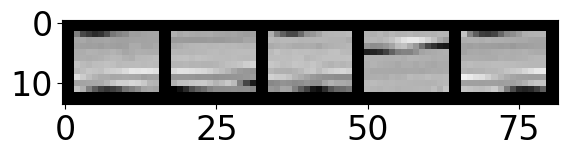

Reconstructed Image:


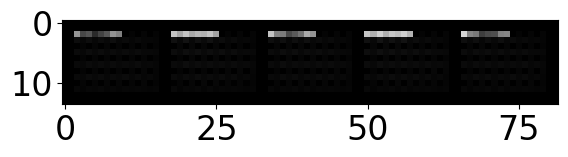

Difference:


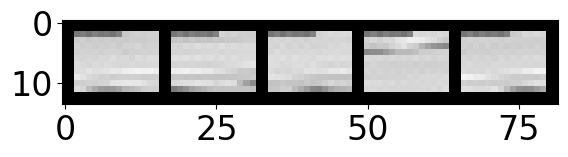



--------------------------------------------------------------------------------


length of losses: 5
Epoch: 2
Training:


  0%|          | 0/1 [00:00<?, ?it/s]

Loss: 1.036 	 L_rec: 0.618 	 L_dist: 0.000 	 L_spar: 0.417 	 L_disen: 0.000


Compute and record loss on validation set
EVAL
conditonal= False
device= cpu


  0%|          | 0/33 [00:00<?, ?it/s]

Loss: 0.549 	 L_rec: 0.392 	 L_dist: 0.000 	 L_spar: 0.157 	 L_disen: 0.000
latent image mean: 0.355 	 latent image std: 0.055


Compute and record loss on test set:
EVAL
conditonal= False
device= cpu


  0%|          | 0/1 [00:00<?, ?it/s]

Loss: 0.945 	 L_rec: 0.590 	 L_dist: 0.000 	 L_spar: 0.356 	 L_disen: 0.000
latent image mean: 0.562 	 latent image std: 0.163


--------------------------------------------------------------------------------


length of losses: 5
Epoch: 3
Training:


  0%|          | 0/1 [00:00<?, ?it/s]

Loss: 0.958 	 L_rec: 0.595 	 L_dist: 0.000 	 L_spar: 0.362 	 L_disen: 0.000


Compute and record loss on validation set
EVAL
conditonal= False
device= cpu


  0%|          | 0/33 [00:00<?, ?it/s]

Loss: 0.492 	 L_rec: 0.365 	 L_dist: 0.000 	 L_spar: 0.127 	 L_disen: 0.000
latent image mean: 0.348 	 latent image std: 0.054


Compute and record loss on test set:
EVAL
conditonal= False
device= cpu


  0%|          | 0/1 [00:00<?, ?it/s]

Loss: 0.860 	 L_rec: 0.561 	 L_dist: 0.000 	 L_spar: 0.299 	 L_disen: 0.000
latent image mean: 0.557 	 latent image std: 0.162


--------------------------------------------------------------------------------


length of losses: 5
Epoch: 4
Training:


  0%|          | 0/1 [00:00<?, ?it/s]

Loss: 0.874 	 L_rec: 0.568 	 L_dist: 0.000 	 L_spar: 0.306 	 L_disen: 0.000


Compute and record loss on validation set
EVAL
conditonal= False
device= cpu


  0%|          | 0/33 [00:00<?, ?it/s]

Loss: 0.429 	 L_rec: 0.332 	 L_dist: 0.000 	 L_spar: 0.097 	 L_disen: 0.000
latent image mean: 0.332 	 latent image std: 0.054


Compute and record loss on test set:
EVAL
conditonal= False
device= cpu


  0%|          | 0/1 [00:00<?, ?it/s]

Loss: 0.765 	 L_rec: 0.527 	 L_dist: 0.000 	 L_spar: 0.238 	 L_disen: 0.000
latent image mean: 0.540 	 latent image std: 0.160


--------------------------------------------------------------------------------


length of losses: 5
Epoch: 5
Training:


  0%|          | 0/1 [00:00<?, ?it/s]

Loss: 0.780 	 L_rec: 0.534 	 L_dist: 0.000 	 L_spar: 0.246 	 L_disen: 0.000


Compute and record loss on validation set
EVAL
conditonal= False
device= cpu


  0%|          | 0/33 [00:00<?, ?it/s]

Loss: 0.360 	 L_rec: 0.292 	 L_dist: 0.000 	 L_spar: 0.068 	 L_disen: 0.000
latent image mean: 0.306 	 latent image std: 0.054


Compute and record loss on test set:
EVAL
conditonal= False
device= cpu


  0%|          | 0/1 [00:00<?, ?it/s]

Loss: 0.663 	 L_rec: 0.486 	 L_dist: 0.000 	 L_spar: 0.177 	 L_disen: 0.000
latent image mean: 0.509 	 latent image std: 0.159
Original Image:


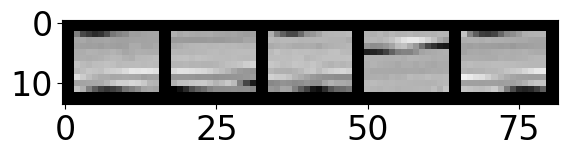

Reconstructed Image:


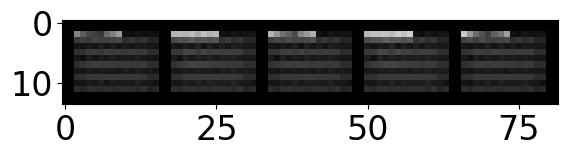

Difference:


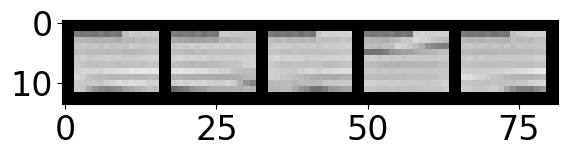



--------------------------------------------------------------------------------


Lowest Validation Loss: 0.359945 was achieved at epoch: 5
Finished Training
conditonal= False
EVAL
conditonal= False
device= cpu


  0%|          | 0/1 [00:00<?, ?it/s]

EVAL
conditonal= False
device= cpu


  0%|          | 0/1 [00:00<?, ?it/s]



################################################################################
################################################################################




Start Training with latent dimension: 16


Node r1 has following input dimensions:
	 Output #0 of node input: (1, 10, 14)

Node conv1 has following input dimensions:
	 Output #0 of node r1: (4, 5, 7)

Node conv2 has following input dimensions:
	 Output #0 of node conv1: (4, 5, 7)

Node conv3 has following input dimensions:
	 Output #0 of node conv2: (4, 5, 7)

Node r2 has following input dimensions:
	 Output #0 of node conv3: (4, 5, 7)

internal_size: 180
internal_size: 180
internal_size: 180
internal_size: 180
Node fc has following input dimensions:
	 Output #0 of node r2: (140,)

Node r3 has following input dimensions:
	 Output #0 of node fc: (140,)

Node r4 has following input dimensions:
	 Output #0 of node r3: (4, 5, 7)

Node output has following input dimensions:
	 Output #0 of node r4: (1, 10, 14)

after init_mode

  0%|          | 0/1 [00:00<?, ?it/s]

Loss: 1.081 	 L_rec: 0.604 	 L_dist: 0.000 	 L_spar: 0.477 	 L_disen: 0.000


Compute and record loss on validation set
EVAL
conditonal= False
device= cpu


  0%|          | 0/33 [00:00<?, ?it/s]

Loss: 0.579 	 L_rec: 0.392 	 L_dist: 0.000 	 L_spar: 0.187 	 L_disen: 0.000
latent image mean: 0.372 	 latent image std: 0.046


Compute and record loss on test set:
EVAL
conditonal= False
device= cpu


  0%|          | 0/1 [00:00<?, ?it/s]

Loss: 0.983 	 L_rec: 0.574 	 L_dist: 0.000 	 L_spar: 0.409 	 L_disen: 0.000
latent image mean: 0.610 	 latent image std: 0.107
Original Image:


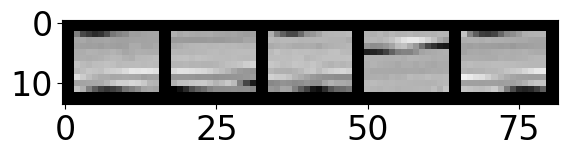

Reconstructed Image:


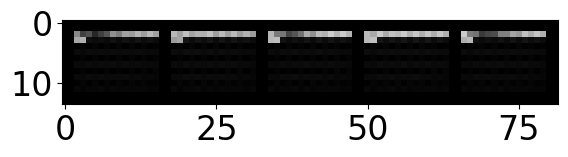

Difference:


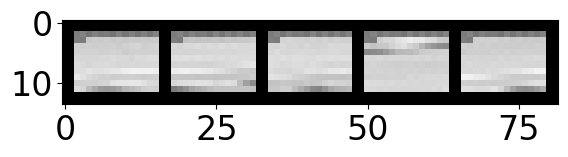



--------------------------------------------------------------------------------


length of losses: 5
Epoch: 2
Training:


  0%|          | 0/1 [00:00<?, ?it/s]

Loss: 1.004 	 L_rec: 0.585 	 L_dist: 0.000 	 L_spar: 0.419 	 L_disen: 0.000


Compute and record loss on validation set
EVAL
conditonal= False
device= cpu


  0%|          | 0/33 [00:00<?, ?it/s]

Loss: 0.523 	 L_rec: 0.367 	 L_dist: 0.000 	 L_spar: 0.156 	 L_disen: 0.000
latent image mean: 0.371 	 latent image std: 0.046


Compute and record loss on test set:
EVAL
conditonal= False
device= cpu


  0%|          | 0/1 [00:00<?, ?it/s]

Loss: 0.897 	 L_rec: 0.547 	 L_dist: 0.000 	 L_spar: 0.350 	 L_disen: 0.000
latent image mean: 0.613 	 latent image std: 0.106


--------------------------------------------------------------------------------


length of losses: 5
Epoch: 3
Training:


  0%|          | 0/1 [00:00<?, ?it/s]

Loss: 0.920 	 L_rec: 0.559 	 L_dist: 0.000 	 L_spar: 0.361 	 L_disen: 0.000


Compute and record loss on validation set
EVAL
conditonal= False
device= cpu


  0%|          | 0/33 [00:00<?, ?it/s]

Loss: 0.463 	 L_rec: 0.338 	 L_dist: 0.000 	 L_spar: 0.125 	 L_disen: 0.000
latent image mean: 0.357 	 latent image std: 0.046


Compute and record loss on test set:
EVAL
conditonal= False
device= cpu


  0%|          | 0/1 [00:00<?, ?it/s]

Loss: 0.807 	 L_rec: 0.515 	 L_dist: 0.000 	 L_spar: 0.292 	 L_disen: 0.000
latent image mean: 0.600 	 latent image std: 0.106


--------------------------------------------------------------------------------


length of losses: 5
Epoch: 4
Training:


  0%|          | 0/1 [00:00<?, ?it/s]

Loss: 0.832 	 L_rec: 0.529 	 L_dist: 0.000 	 L_spar: 0.303 	 L_disen: 0.000


Compute and record loss on validation set
EVAL
conditonal= False
device= cpu


  0%|          | 0/33 [00:00<?, ?it/s]

Loss: 0.397 	 L_rec: 0.303 	 L_dist: 0.000 	 L_spar: 0.094 	 L_disen: 0.000
latent image mean: 0.336 	 latent image std: 0.046


Compute and record loss on test set:
EVAL
conditonal= False
device= cpu


  0%|          | 0/1 [00:00<?, ?it/s]

Loss: 0.710 	 L_rec: 0.478 	 L_dist: 0.000 	 L_spar: 0.232 	 L_disen: 0.000
latent image mean: 0.577 	 latent image std: 0.107


--------------------------------------------------------------------------------


length of losses: 5
Epoch: 5
Training:


  0%|          | 0/1 [00:00<?, ?it/s]

Loss: 0.736 	 L_rec: 0.492 	 L_dist: 0.000 	 L_spar: 0.243 	 L_disen: 0.000


Compute and record loss on validation set
EVAL
conditonal= False
device= cpu


  0%|          | 0/33 [00:00<?, ?it/s]

Loss: 0.326 	 L_rec: 0.260 	 L_dist: 0.000 	 L_spar: 0.065 	 L_disen: 0.000
latent image mean: 0.307 	 latent image std: 0.047


Compute and record loss on test set:
EVAL
conditonal= False
device= cpu


  0%|          | 0/1 [00:00<?, ?it/s]

Loss: 0.608 	 L_rec: 0.433 	 L_dist: 0.000 	 L_spar: 0.174 	 L_disen: 0.000
latent image mean: 0.544 	 latent image std: 0.108
Original Image:


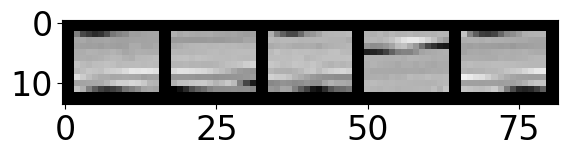

Reconstructed Image:


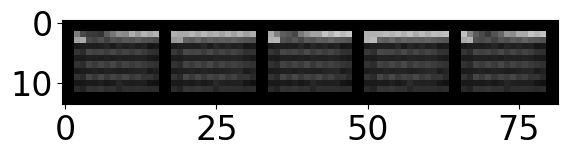

Difference:


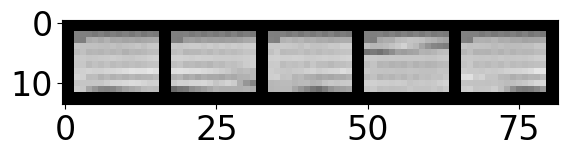



--------------------------------------------------------------------------------


Lowest Validation Loss: 0.325836 was achieved at epoch: 5
Finished Training
conditonal= False
EVAL
conditonal= False
device= cpu


  0%|          | 0/1 [00:00<?, ?it/s]

EVAL
conditonal= False
device= cpu


  0%|          | 0/1 [00:00<?, ?it/s]



################################################################################
################################################################################




Start Training with latent dimension: 32


Node r1 has following input dimensions:
	 Output #0 of node input: (1, 10, 14)

Node conv1 has following input dimensions:
	 Output #0 of node r1: (4, 5, 7)

Node conv2 has following input dimensions:
	 Output #0 of node conv1: (4, 5, 7)

Node conv3 has following input dimensions:
	 Output #0 of node conv2: (4, 5, 7)

Node r2 has following input dimensions:
	 Output #0 of node conv3: (4, 5, 7)

internal_size: 180
internal_size: 180
internal_size: 180
internal_size: 180
Node fc has following input dimensions:
	 Output #0 of node r2: (140,)

Node r3 has following input dimensions:
	 Output #0 of node fc: (140,)

Node r4 has following input dimensions:
	 Output #0 of node r3: (4, 5, 7)

Node output has following input dimensions:
	 Output #0 of node r4: (1, 10, 14)

after init_mode

  0%|          | 0/1 [00:00<?, ?it/s]

Loss: 1.026 	 L_rec: 0.535 	 L_dist: 0.000 	 L_spar: 0.491 	 L_disen: 0.000


Compute and record loss on validation set
EVAL
conditonal= False
device= cpu


  0%|          | 0/33 [00:00<?, ?it/s]

Loss: 0.529 	 L_rec: 0.341 	 L_dist: 0.000 	 L_spar: 0.187 	 L_disen: 0.000
latent image mean: 0.400 	 latent image std: 0.036


Compute and record loss on test set:
EVAL
conditonal= False
device= cpu


  0%|          | 0/1 [00:00<?, ?it/s]

Loss: 0.913 	 L_rec: 0.502 	 L_dist: 0.000 	 L_spar: 0.411 	 L_disen: 0.000
latent image mean: 0.615 	 latent image std: 0.087
Original Image:


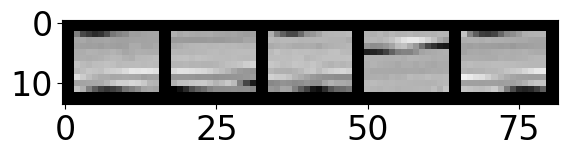

Reconstructed Image:


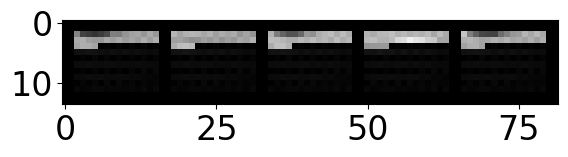

Difference:


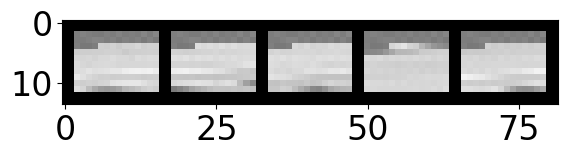



--------------------------------------------------------------------------------


length of losses: 5
Epoch: 2
Training:


  0%|          | 0/1 [00:00<?, ?it/s]

Loss: 0.953 	 L_rec: 0.520 	 L_dist: 0.000 	 L_spar: 0.433 	 L_disen: 0.000


Compute and record loss on validation set
EVAL
conditonal= False
device= cpu


  0%|          | 0/33 [00:00<?, ?it/s]

Loss: 0.476 	 L_rec: 0.320 	 L_dist: 0.000 	 L_spar: 0.156 	 L_disen: 0.000
latent image mean: 0.379 	 latent image std: 0.036


Compute and record loss on test set:
EVAL
conditonal= False
device= cpu


  0%|          | 0/1 [00:00<?, ?it/s]

Loss: 0.830 	 L_rec: 0.479 	 L_dist: 0.000 	 L_spar: 0.351 	 L_disen: 0.000
latent image mean: 0.590 	 latent image std: 0.086


--------------------------------------------------------------------------------


length of losses: 5
Epoch: 3
Training:


  0%|          | 0/1 [00:00<?, ?it/s]

Loss: 0.870 	 L_rec: 0.497 	 L_dist: 0.000 	 L_spar: 0.373 	 L_disen: 0.000


Compute and record loss on validation set
EVAL
conditonal= False
device= cpu


  0%|          | 0/33 [00:00<?, ?it/s]

Loss: 0.418 	 L_rec: 0.294 	 L_dist: 0.000 	 L_spar: 0.124 	 L_disen: 0.000
latent image mean: 0.354 	 latent image std: 0.036


Compute and record loss on test set:
EVAL
conditonal= False
device= cpu


  0%|          | 0/1 [00:00<?, ?it/s]

Loss: 0.743 	 L_rec: 0.452 	 L_dist: 0.000 	 L_spar: 0.290 	 L_disen: 0.000
latent image mean: 0.561 	 latent image std: 0.086


--------------------------------------------------------------------------------


length of losses: 5
Epoch: 4
Training:


  0%|          | 0/1 [00:00<?, ?it/s]

Loss: 0.780 	 L_rec: 0.469 	 L_dist: 0.000 	 L_spar: 0.311 	 L_disen: 0.000


Compute and record loss on validation set
EVAL
conditonal= False
device= cpu


  0%|          | 0/33 [00:00<?, ?it/s]

Loss: 0.355 	 L_rec: 0.263 	 L_dist: 0.000 	 L_spar: 0.093 	 L_disen: 0.000
latent image mean: 0.326 	 latent image std: 0.036


Compute and record loss on test set:
EVAL
conditonal= False
device= cpu


  0%|          | 0/1 [00:00<?, ?it/s]

Loss: 0.649 	 L_rec: 0.420 	 L_dist: 0.000 	 L_spar: 0.229 	 L_disen: 0.000
latent image mean: 0.528 	 latent image std: 0.085


--------------------------------------------------------------------------------


length of losses: 5
Epoch: 5
Training:


  0%|          | 0/1 [00:00<?, ?it/s]

Loss: 0.683 	 L_rec: 0.436 	 L_dist: 0.000 	 L_spar: 0.248 	 L_disen: 0.000


Compute and record loss on validation set
EVAL
conditonal= False
device= cpu


  0%|          | 0/33 [00:00<?, ?it/s]

Loss: 0.289 	 L_rec: 0.225 	 L_dist: 0.000 	 L_spar: 0.064 	 L_disen: 0.000
latent image mean: 0.293 	 latent image std: 0.036


Compute and record loss on test set:
EVAL
conditonal= False
device= cpu


  0%|          | 0/1 [00:00<?, ?it/s]

Loss: 0.552 	 L_rec: 0.383 	 L_dist: 0.000 	 L_spar: 0.169 	 L_disen: 0.000
latent image mean: 0.489 	 latent image std: 0.084
Original Image:


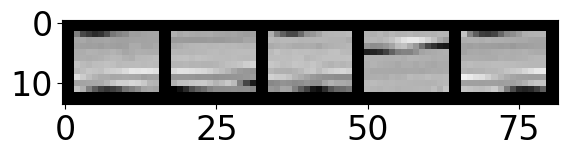

Reconstructed Image:


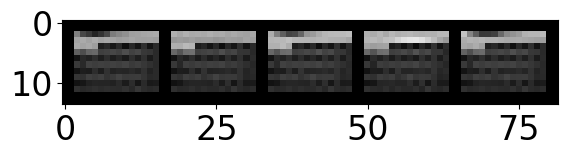

Difference:


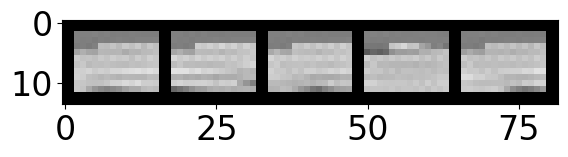



--------------------------------------------------------------------------------


Lowest Validation Loss: 0.289068 was achieved at epoch: 5
Finished Training
conditonal= False
EVAL
conditonal= False
device= cpu


  0%|          | 0/1 [00:00<?, ?it/s]

EVAL
conditonal= False
device= cpu


  0%|          | 0/1 [00:00<?, ?it/s]



################################################################################
################################################################################




In [ ]:
### Training

model = train_bottleneck(num_epoch, get_model, 'l1', modelname, milestones, latent_dim_lst, trainloader,
                            abnormalloader, testloader, a_distr=0, a_disen=0, lr_init=lr_init, l2_reg=l2_reg, device=device, save_model=True)



Latent Dimension:  8
Original Image:


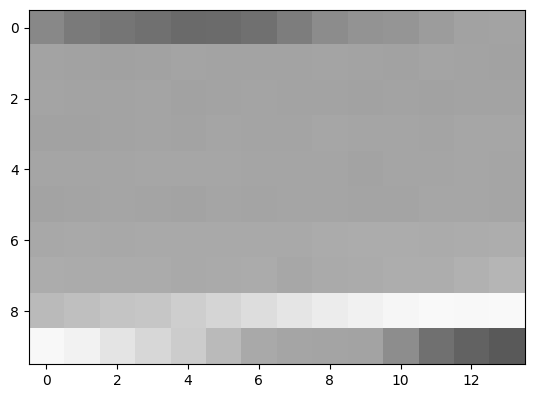

Reconstructed Image:


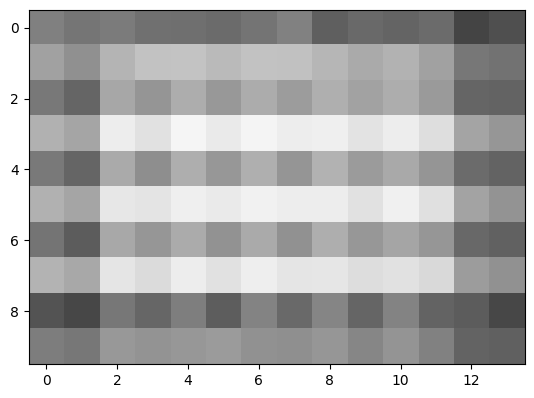

Difference:


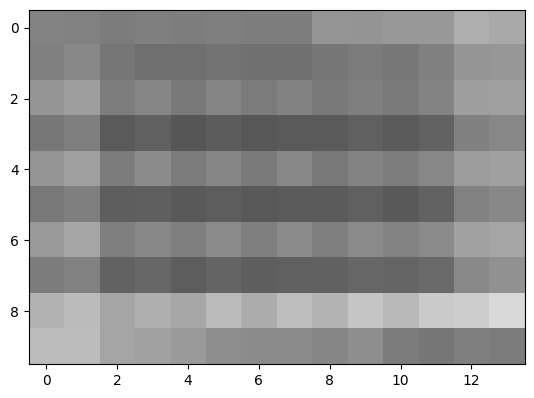

Latent Dimension:  16
Original Image:


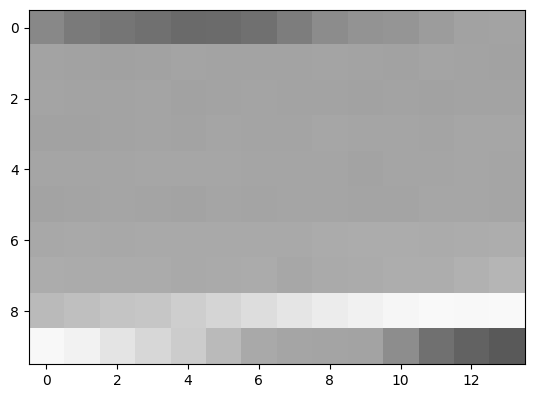

Reconstructed Image:


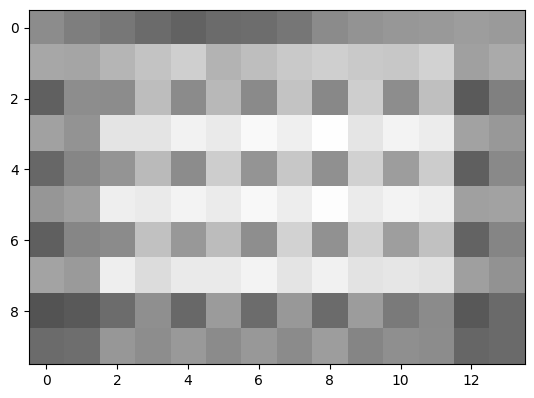

Difference:


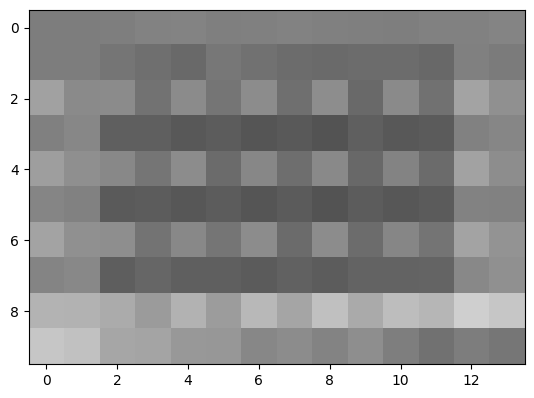

Latent Dimension:  32
Original Image:


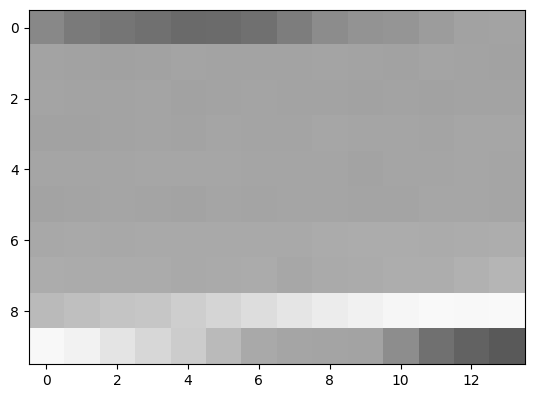

Reconstructed Image:


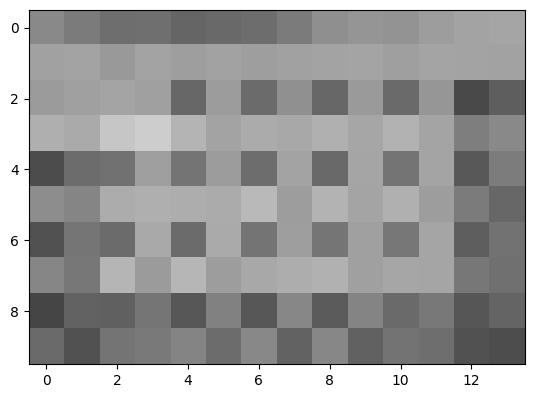

Difference:


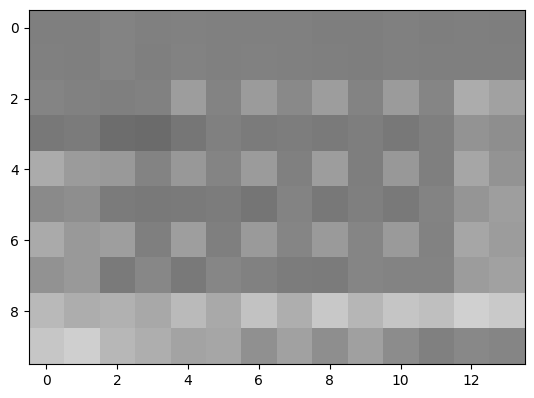

In [ ]:
# Plot Reconstruction and Difference Images Examples
# Skip. Gives no compehensible info
pl.plot_diff_all(get_model, modelname, num_epoch, testloader, latent_dim_lst, device='cpu', num_img=1, grid_row_size=10, figsize=(30, 30),
              filename=None, conditional=False)

[0.4859142303466797, 0.433255672454834, 0.3828863203525543]


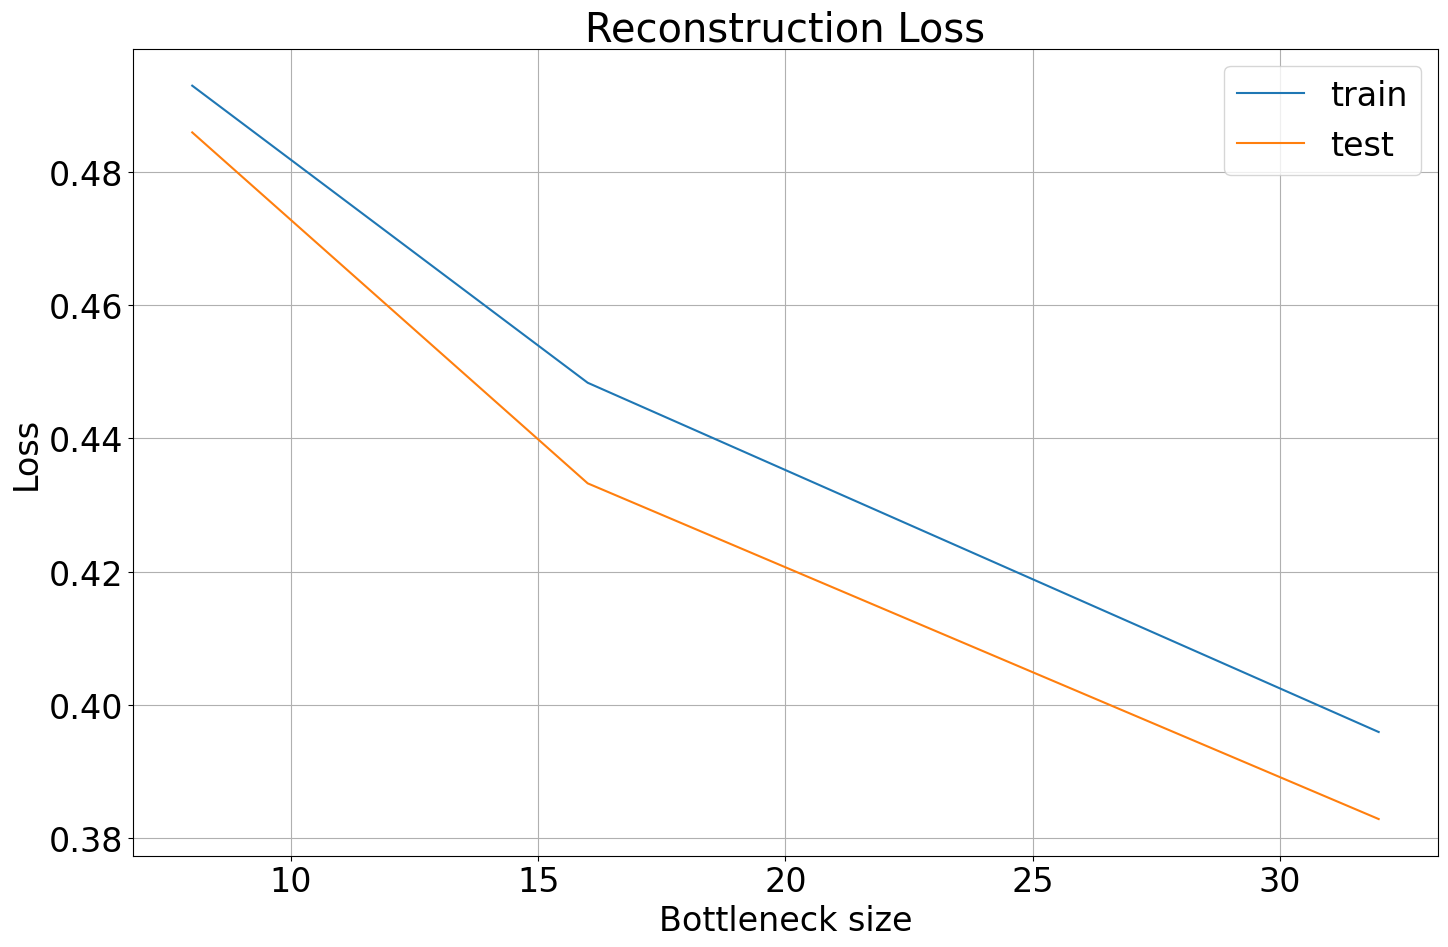

In [ ]:
# Plot Recontruction Loss against Bottleneck Size
_, l1_rec_test, _, _, _ = fm.load_variable('bottleneck_test_loss_{}'.format(modelname), modelname)
_, l1_rec_train, _, _, _ = fm.load_variable('bottleneck_train_loss_{}'.format(modelname), modelname)

print(l1_rec_test)

pl.plot(latent_dim_lst, [l1_rec_train, l1_rec_test], 'Bottleneck size', 'Loss', ['train', 'test'], 'Reconstruction Loss', '{}_bottleneck_History'.format(modelname))


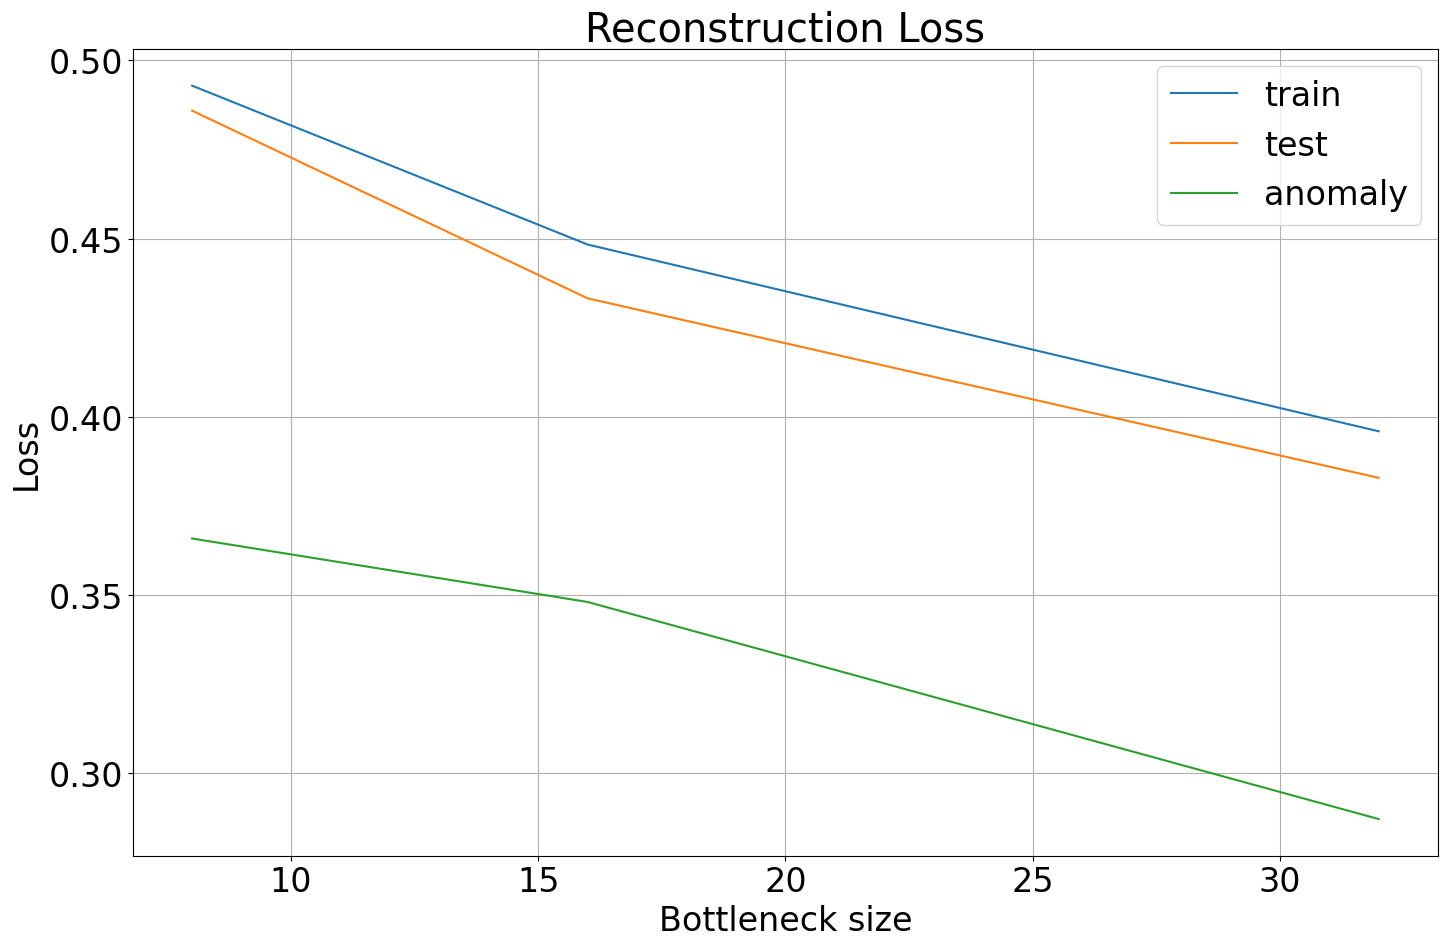

In [ ]:
# This is needed for the the chart, but populated manually with the lowest validation loss for every bottleneck size
# Need to figure out how to set a variable in the tarining loop to capture it

l1_rec_test_val = [0.145150, 0.115978, 0.111309]  # Dataset 1
l1_rec_test_val = [0.230440, 0.221233, 0.181769]  # Dataset 2
l1_rec_test_val = [0.153440, 0.167759, 0.135068]  # Dataset 3
l1_rec_test_val = [0.165767, 0.154690, 0.115024]  # Dataset 4
l1_rec_test_val = [0.365866, 0.348058, 0.287148]  # Dataset 5
l1_rec_test_val = [0.138940, 0.154894, 0.117232]  # Dataset 3 second try
l1_rec_test_val = [0.145150, 0.115978, 0.111309]  # Dataset 1
l1_rec_test_val = [0.153440, 0.167759, 0.135068]  # Dataset 3
l1_rec_test_val = [0.153821, 0.158172, 0.135693]  # Dataset 3
l1_rec_test_val = [0.165767, 0.154690, 0.115024]  # Dataset 4
l1_rec_test_val = [0.365866, 0.348058, 0.287148]  # Dataset 5

pl.plot(latent_dim_lst, [l1_rec_train, l1_rec_test, l1_rec_test_val], 'Bottleneck size', 'Loss', ['train', 'test', 'anomaly'], 'Reconstruction Loss', '{}_bottleneck_History'.format(modelname))
